In [4]:
# 2.2.1 - Per Channel Color Histogram
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Read in an image
image = cv2.imread('q_1.jpg')
# Take each channel
image_b = image[:,:,0]
image_g = image[:,:,1]
image_r = image[:,:,2]
image_b.shape
image.shape

(96, 96, 3)

In [6]:
# write the version of this function with no for loops
def per_channel_histogram(image,interval):
    histogram_b = np.bincount(np.int_(image[:,:,0].flatten()/interval),minlength=int(256/interval))
    histogram_g = np.bincount(np.int_(image[:,:,1].flatten()/interval),minlength=int(256/interval))
    histogram_r = np.bincount(np.int_(image[:,:,2].flatten()/interval),minlength=int(256/interval))
    #take an array of three histograms
    histogram = np.array([histogram_b, histogram_g, histogram_r])
    return histogram


In [7]:
print(per_channel_histogram(image,64))

[[4880 3716  579   41]
 [1019 5024 2970  203]
 [3411 3239 2313  253]]


In [8]:
def color_3d_histogram(image,interval):
    r_combinations, g_combinations, b_combinations = np.meshgrid(np.arange(len(per_channel_histogram(image,interval)[0])), np.arange(len(per_channel_histogram(image,interval)[1])), np.arange(len(per_channel_histogram(image,interval)[2])), indexing='ij')
    comb_arr = np.stack([r_combinations, g_combinations, b_combinations], axis=-1)
    flattened = comb_arr.reshape((-1, 3)).astype("uint32")
    histogram_3d = np.zeros((int(256/interval)**3))
    for flat in flattened: 
        index = int(flat[0] * (256/interval) ** 2 + flat[1] * (256/interval) + flat[2])
        histogram_3d[index] = per_channel_histogram(image,interval)[0][flat[0]] + per_channel_histogram(image,interval)[1][flat[1]] + per_channel_histogram(image,interval)[2][flat[2]]
    return histogram_3d

In [56]:
def split_image(image, grid_size):

    # Get the dimensions of the original image
    height, width, channels = image.shape

    # Calculate the size of each grid cell
    cell_height = height // grid_size
    cell_width = width // grid_size

    # Reshape the image to a 2D array to make slicing easier
    reshaped_image = image.reshape(grid_size, cell_height, grid_size, cell_width, channels)

    # Swap axes to get the final grid
    grid = reshaped_image.transpose(0, 2, 1, 3, 4).reshape(-1, cell_height, cell_width, channels)

    return grid

def extract_grid_histograms(image,grid,interval):
    size = int(96 / grid)
    hists = []
    for i in range(0, grid):
        for j in range(0, grid):
            p = image[i * size:(i + 1) * size, j * size:(j + 1) * size]
            hists.append(per_channel_histogram(p,interval))
    return np.array(hists)

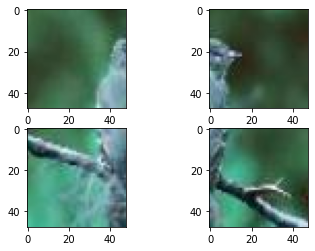

In [42]:

#plot the splitted image with 2,2 subplots
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(split_image(image, 2)[0])
ax[0,1].imshow(split_image(image, 2)[1])
ax[1,0].imshow(split_image(image, 2)[2])
ax[1,1].imshow(split_image(image, 2)[3])


In [11]:
def rgb_to_hsv(image):
    #convert bgr to rgb with numpy
    image = image[:, :, ::-1]
    height, width, channels = image.shape
    img_exp = np.expand_dims(image, axis=0)
    
    img_exp =  img_exp.reshape(-1, channels) / 255.0
    r,g,b = img_exp[:,2], img_exp[:,1], img_exp[:,0]
    maxc = np.maximum(np.maximum(r,g),b)
    max_index = np.argmax(img_exp,axis = 1)
    minc = np.minimum(np.minimum(r,g),b)
    delta = maxc - minc 

    value = maxc

    # saturation is 0 if maxc = 0, delta/maxc if maxc>0
    saturation = (maxc > 0) * (delta / maxc)

    nonzero_delta = delta != 0
    hue = np.zeros(maxc.shape)
    mask1 = (max_index == 0) & nonzero_delta
    mask2 = (max_index == 1) & nonzero_delta
    mask3 = (max_index == 2) & nonzero_delta


    hue[mask1] = (1/6) * (((img_exp[mask1,1]-img_exp[mask1,2])/delta[mask1]) % 6)
    hue[mask2] = (1/6) * (((img_exp[mask2,2]-img_exp[mask2,1])/delta[mask2]) + 2 )
    hue[mask3] = (1/6) * (((img_exp[mask3,0]-img_exp[mask3,1])/delta[mask3]) + 4 )
    

    # map between 0 and 255
    hue = hue * 255
    hue = hue.astype("uint8")
    saturation = saturation * 255
    saturation = saturation.astype("uint8")
    value = value * 255
    value = value.astype("uint8")

    hsv_image = np.stack([hue, saturation, value], axis=-1)
    hsv_image = hsv_image.reshape(height,width,channels)
    return hsv_image

In [12]:
np.max(rgb_to_hsv(image)[:,:,2])

255

In [13]:
def l1(hist):
    prob_dist = hist / np.sum(hist)
    return prob_dist

In [14]:
def similarity_check_per_channel(image1,image2,interval):
    histogram_1 = per_channel_histogram(image1,interval)
    histogram_2 = per_channel_histogram(image2,interval)
    #calculate the similarity between those two histograms for each channel and take an average
    sm1 = np.sum(np.minimum(l1(histogram_1[0]),l1(histogram_2[0])))
    sm2 = np.sum(np.minimum(l1(histogram_1[1]),l1(histogram_2[1])))
    sm3 = np.sum(np.minimum(l1(histogram_1[2]),l1(histogram_2[2])))
    similarity = (sm1 + sm2 + sm3)/3
    return similarity
def similarity_check_per_channel_histograms(histogram_1,histogram_2):
    sm1 = np.sum(np.minimum(l1(histogram_1[0]),l1(histogram_2[0])))
    sm2 = np.sum(np.minimum(l1(histogram_1[1]),l1(histogram_2[1])))
    sm3 = np.sum(np.minimum(l1(histogram_1[2]),l1(histogram_2[2])))
    similarity = (sm1 + sm2 + sm3)/3
    return similarity

In [15]:
similarity_check_per_channel(image,cv2.imread("q_2.jpg"),64)

0.9746817129629629

In [16]:
def similarity_check_3d(image1,image2,interval):
    histogram_1 = color_3d_histogram(image1,interval)
    histogram_2 = color_3d_histogram(image2,interval)
    #calculate the similarity between those two histograms for each channel and take an average
    similarity = np.sum(np.minimum(l1(histogram_1),l1(histogram_2)))
    return similarity

def similarity_check_3d_histograms(histogram_1,histogram_2):
    #calculate the similarity between those two histograms for each channel and take an average
    similarity = np.sum(np.minimum(l1(histogram_1),l1(histogram_2)))
    return similarity

In [17]:
similarity_check_3d(image,cv2.imread("q_2.jpg"),128)

0.9954065393518519

In [69]:
#get the images in the suppord_96 folder
import os
import glob
import cv2
import numpy as np

def get_images(path):
    #get all the images in the directory
    images = [cv2.imread(file) for file in glob.glob(path)]
    return images
def get_image_names(path):
    #get all the images in the directory
    images = [file.split(os.sep)[1] for file in glob.glob(path)]
    return images

images_support = get_images("support_96/*.jpg")
image_names_support = get_image_names("support_96/*.jpg")
images_query1 = get_images("query_1/*.jpg")
image_names_query1 = get_image_names("query_1/*.jpg")
images_query2 = get_images("query_2/*.jpg")
image_names_query2 = get_image_names("query_2/*.jpg")
images_query3 = get_images("query_3/*.jpg")
image_names_query3 = get_image_names("query_3/*.jpg")

def top1_calculator(support,query,names_support,names_query,interval,type,hsv_true):
    counter = 0
    if hsv_true:
        supportcop = []
        querycop = []
        for xk in range(len(support)):
            supportcop.append(rgb_to_hsv(support[xk]))
        for yk in range(len(query)):
            querycop.append(rgb_to_hsv(query[yk]))
    else:
        supportcop = support
        querycop = query
            
    if type == '3d':
        histlistsupport = np.array([color_3d_histogram(i, interval) for i in supportcop])
        histlistquery = np.array([color_3d_histogram(i, interval) for i in querycop])
        for i in range(len(histlistquery)):
            similarities = np.array([similarity_check_3d_histograms(histlistquery[i], histlistsupport[j]) for j in range(len(histlistsupport))])
            if names_query[i]==names_support[np.argmax(similarities)]:
                counter+=1
    elif type == 'per_channel':
        histlistsupport = np.array([per_channel_histogram(i, interval) for i in supportcop])
        histlistquery = np.array([per_channel_histogram(i, interval) for i in querycop])
        for i in range(len(histlistquery)):
            similarities = np.array([similarity_check_per_channel_histograms(histlistquery[i], histlistsupport[j]) for j in range(len(histlistsupport))])
            if names_query[i]==names_support[np.argmax(similarities)]:
                counter+=1
    print("Top1 Accuracy: ",counter/len(histlistquery)*100)
    
query_names = [image_names_query1,image_names_query2,image_names_query3]
for i in [16,32,64,128]:
    print("------------------------------------")
    for j,query in enumerate([images_query1,images_query2,images_query3]):
        print("Interval: ",i,"Query: ",str(j+1),"HSV: ",False)
        top1_calculator(images_support,query,image_names_support,query_names[j],i,'per_channel',True)


#top1_calculator(images_support,images_query3,image_names_support,image_names_query3,128,'per_channel',True)

'''top1_calculator(images_support,images_query1,image_names_support,image_names_query1,128,'per_channel',False)
top1_calculator(images_support,images_query1,image_names_support,image_names_query1,64,'per_channel',False)
top1_calculator(images_support,images_query1,image_names_support,image_names_query1,32,'per_channel',False)
top1_calculator(images_support,images_query1,image_names_support,image_names_query1,16,'per_channel',False)
top1_calculator(images_support,images_query1,image_names_support,image_names_query1,8,'per_channel',False)'''



------------------------------------
Interval:  16 Query:  1 HSV:  False


/var/folders/5g/0xxgsr2j6s7g8hpg6j_tm2km0000gn/T/ipykernel_59790/373732205.py:17: RuntimeWarning: invalid value encountered in true_divide
  saturation = (maxc > 0) * (delta / maxc)


Top1 Accuracy:  100.0
Interval:  16 Query:  2 HSV:  False
Top1 Accuracy:  100.0
Interval:  16 Query:  3 HSV:  False
Top1 Accuracy:  38.0
------------------------------------
Interval:  32 Query:  1 HSV:  False
Top1 Accuracy:  100.0
Interval:  32 Query:  2 HSV:  False
Top1 Accuracy:  100.0
Interval:  32 Query:  3 HSV:  False
Top1 Accuracy:  37.5
------------------------------------
Interval:  64 Query:  1 HSV:  False
Top1 Accuracy:  97.0
Interval:  64 Query:  2 HSV:  False
Top1 Accuracy:  100.0
Interval:  64 Query:  3 HSV:  False
Top1 Accuracy:  39.0
------------------------------------
Interval:  128 Query:  1 HSV:  False
Top1 Accuracy:  63.5
Interval:  128 Query:  2 HSV:  False
Top1 Accuracy:  100.0
Interval:  128 Query:  3 HSV:  False
Top1 Accuracy:  18.0


"top1_calculator(images_support,images_query1,image_names_support,image_names_query1,128,'per_channel',False)\ntop1_calculator(images_support,images_query1,image_names_support,image_names_query1,64,'per_channel',False)\ntop1_calculator(images_support,images_query1,image_names_support,image_names_query1,32,'per_channel',False)\ntop1_calculator(images_support,images_query1,image_names_support,image_names_query1,16,'per_channel',False)\ntop1_calculator(images_support,images_query1,image_names_support,image_names_query1,8,'per_channel',False)"

In [73]:
#get the images in the suppord_96 folder
import os
import glob
import cv2
import numpy as np

def get_images(path):
    #get all the images in the directory
    images = [cv2.imread(file) for file in glob.glob(path)]
    return images
def get_image_names(path):
    #get all the images in the directory
    images = [file.split(os.sep)[1] for file in glob.glob(path)]
    return images

images_support = get_images("support_96/*.jpg")
image_names_support = get_image_names("support_96/*.jpg")
images_query1 = get_images("query_1/*.jpg")
image_names_query1 = get_image_names("query_1/*.jpg")
images_query2 = get_images("query_2/*.jpg")
image_names_query2 = get_image_names("query_2/*.jpg")
images_query3 = get_images("query_3/*.jpg")
image_names_query3 = get_image_names("query_3/*.jpg")

def top1_calculator_grid(support,query,names_support,names_query,interval,type,hsv_true,grid_size):
    counter = 0
    if hsv_true:
        supportcop = []
        querycop = []
        for xk in range(len(support)):
            supportcop.append(rgb_to_hsv(support[xk]))
        for yk in range(len(query)):
            querycop.append(rgb_to_hsv(query[yk]))
    else:
        supportcop = support
        querycop = query
    
    support_grid = np.array([split_image(i, grid_size) for i in supportcop])
    query_grid = np.array([split_image(i, grid_size) for i in querycop])

    if type == '3d':

        histlistsupport = np.array([[color_3d_histogram(j, interval) for j in i] for i in support_grid])
        histlistquery = np.array([[color_3d_histogram(j, interval) for j in i] for i in query_grid])

        for i in range(len(histlistquery)):
            similarity_score = np.zeros(200)
            for j in range(len(histlistsupport)):
                similarity_grid = [similarity_check_3d_histograms(histlistquery[i][k], histlistsupport[j][k]) for k in range(grid_size * grid_size)]
                
                similarity_score[j] += np.sum(np.array(similarity_grid))/len(similarity_grid)

            if names_query[i]==names_support[np.argmax(similarity_score)]:
                counter+=1
    elif type == 'per_channel':

        histlistsupport = np.array([[per_channel_histogram(j, interval) for j in i] for i in support_grid])
        histlistquery = np.array([[per_channel_histogram(j, interval) for j in i] for i in query_grid])
        
        for i in range(len(histlistquery)):
            similarities = np.array([np.mean([similarity_check_per_channel_histograms(histlistquery[i][k], histlistsupport[j][k]) for k in range(grid_size * grid_size)]) for j in range(len(histlistsupport))])
            if names_query[i]==names_support[np.argmax(similarities)]:
                counter+=1
        
    
    print("Top1 Accuracy: ",counter/len(names_query)*100)
    return counter/len(names_query)*100

top1_calculator_grid(images_support,images_query2,image_names_support,image_names_query3,8,'per_channel',True,2)

/var/folders/5g/0xxgsr2j6s7g8hpg6j_tm2km0000gn/T/ipykernel_59790/373732205.py:17: RuntimeWarning: invalid value encountered in true_divide
  saturation = (maxc > 0) * (delta / maxc)


Top1 Accuracy:  64.5


64.5